### Import Library

In [27]:
import cv2
import imutils
import matplotlib.pyplot as plt
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

### Input Image

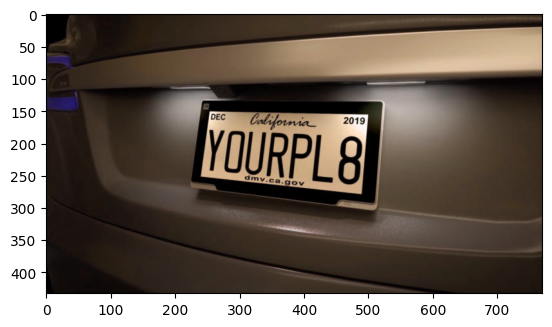

In [28]:
img_input = cv2.imread('img/img3.jpg')
plt.imshow(img_input)

### Preprocessing

Preprocessing berguna memaksimalkan gambar agar hasil edge detection lebih baik pada semua variasi gambar. Untuk proses ini sebenarnya ada banyak, tidak hanya seperti di bawah saja (perlu eksplorasi lebih lanjut nanti). Ada grayscaling, thresholding, blur, filter, morphological transform (erosion, dilation, opening, closing, top-hat, black-hat).

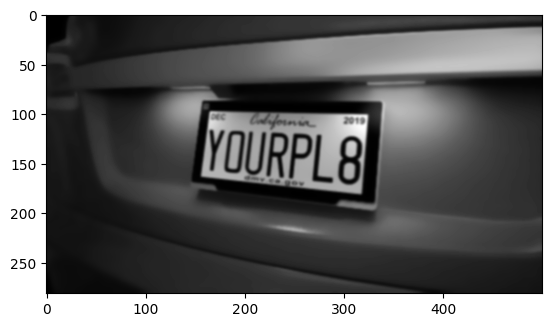

In [29]:
# resize image
img_input = imutils.resize(img_input, width=500)

# convert to grayscale image
img_gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)

# noise removal using bilateral filter
img_gray = cv2.bilateralFilter(img_gray,11,17,17)

# blur image
img_gray = cv2.GaussianBlur(img_gray, (5,5),0)

plt.imshow(img_gray, cmap="gray")

### License Plate Detection
#### Edge Detection

Edge detection digunakan untuk mendeteksi garis tepi pada gambar. Ada beberapa metode yang dapat digunakan yaitu sobel, prewitt, canny. Alasan untuk menggunakan canny di bawah adalah karena canny lebih jelas dalam mendeteksitepi dan juga ada noise removal.

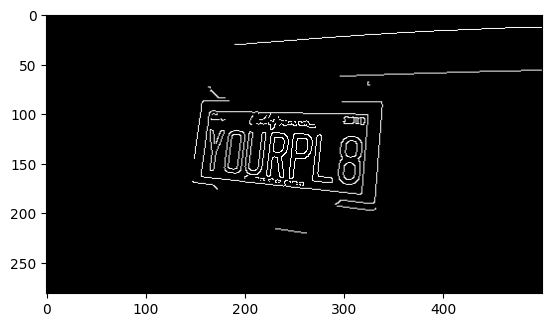

In [30]:
# canny edge detection using thight threshold
edged_image = cv2.Canny(img_gray, 170,200)

# canny edge detection using auto threshold based on image median
# edged_image = imutils.auto_canny(img_gray)

plt.imshow(edged_image,cmap="gray")

#### Find Contours

Contours adalah garis atau kurva yang mengelilingi objek pada gambar, terbentuk dari banyak titik yang saling menyambung. Untuk mencari contours perlu gambar biner (hasil edge detection).

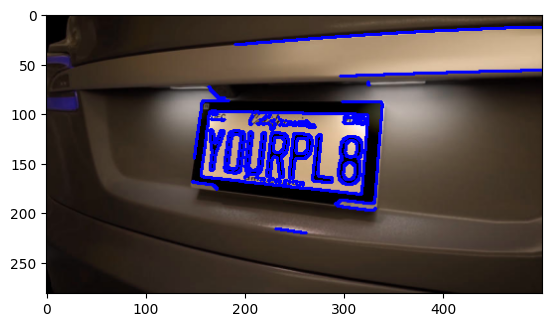

In [31]:
# find contours and save it to list
contours, new = cv2.findContours(edged_image.copy(),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# plot contours to image
img1 = img_input.copy()
cv2.drawContours(img1, contours, -1, (0,0,255),2)
plt.imshow(img1)

####  Sorting Contours

Mengurutkan contours berdasarkan luasnya (dari yang terluas) dan mengambil sekian saja. Hal ini dilakukan karena plat nomer kemungkinan memiliki luas yang lebih besar dibanding contour lain yang terdeteksi. Proses ini juga sekaligus mempercepat proses pencarian contour plat nomer nanti.

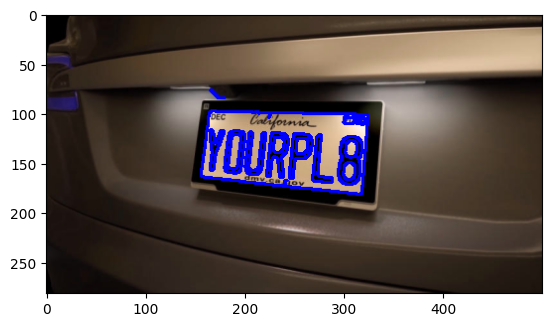

In [32]:
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

# plot contours to image
img2 = img_input.copy()
cv2.drawContours(img2,sorted_contours,-1,(0,0,255),2)
plt.imshow(img2)

#### Looping over Sorted Contours

Pada tahap ini akan mencari contour yang memiliki 4 titik sudut (sesuai dengan bentuk plat nomor). Caranya adalah dengan estimasi bentuk contour menjadi contour yang lebih sederhana (jumlah sudutnya sedikit). Cara tersebut merupakan implementasi dari [Douglas-Peucker algorithm][def].

Hasil dari estimasi bentuk contour ini kadang tidak sesuai dengan yang kita inginkan. Kita perlu mengatur nilai epilson (jarak maksimum dari kontur ke kontur yang diperkirakan) pada parameter method-nya.

[def]: http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm

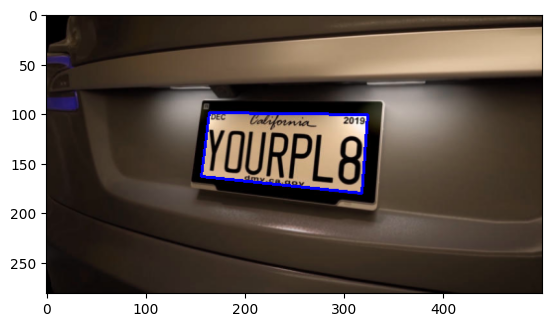

In [33]:
# store license plate contour
plate_contour = None

for c in sorted_contours:
    # find corner on contour based on contour approximation
    contour_perimeter = cv2.arcLength(c,True)
    epilson = 0.018 * contour_perimeter
    approx = cv2.approxPolyDP(c,epilson,True)
    
    # find contour with 4 corner
    if len(approx) == 4:
        plate_contour = approx
        break
    
img3 = img_input.copy()
cv2.drawContours(img3, [plate_contour], -1, (0,0,255),2)
plt.imshow(img3)

### OCR License Plate

Crop gambar sesuai titik pada contour plat nomor. Untuk pengenalan plat nomor-nya menggunakan library easyocr.

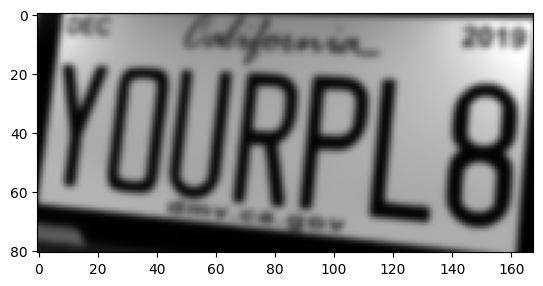

In [39]:
x1, x2 = min(plate_contour[:,0][:,1]), max(plate_contour[:,0][:,1])
y1, y2 = min(plate_contour[:,0][:,0]), max(plate_contour[:,0][:,0])

img_roi = img_gray.copy()
img_roi = img_roi[x1:x2,y1:y2]
plt.imshow(img_roi,cmap="gray")

In [50]:
result = reader.readtext(img_roi)
license_plate_text = result[0][-2]
result

[([[0, 5], [168, 5], [168, 81], [0, 81]], 'YOURPL8', 0.5363336832619047)]

### Final Result

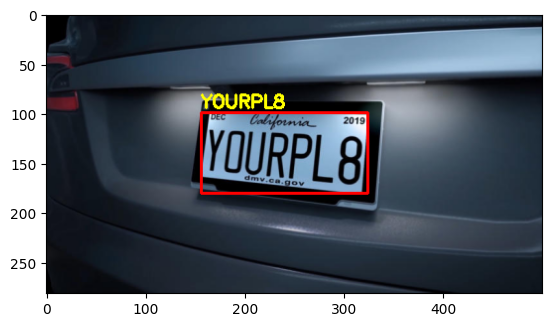

In [55]:
final_img = img_input.copy()
cv2.rectangle(final_img, (y1,x1),(y2,x2),(0,0,255),2)
cv2.putText(final_img, license_plate_text, (y1,x1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

### Evaluation

- Gambar yang berhasil terdeteksi: 3,6,7,11,13,16,17,18
- Hasil belum maksimal, asumsi kenapa ada yang gagal:
  - Kualitas gambar memengaruhi
  - Plat nomor terlalu kecil pada gambar
  - Sudut gambar plat nomor tidak dari depan
  - Warna antara karakter, background, dan garis tepi dari plat nomor yang terlalu kontras
    - Misal: karakter putih, background hitam, dan garis tepi hitam
  - **Perlu tahap lain pada preprocessing** (TODO Next)

### Reference
- [OpenCV Documentation](https://opencv24-python-tutorials.readthedocs.io/en/latest/index.html)
- [License Plate Detection](https://www.section.io/engineering-education/license-plate-detection-and-recognition-using-opencv-and-pytesseract/)